In [27]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

from tensorflow import keras
from keras import datasets, layers, models, losses
from random import choice

# for the clustering part
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

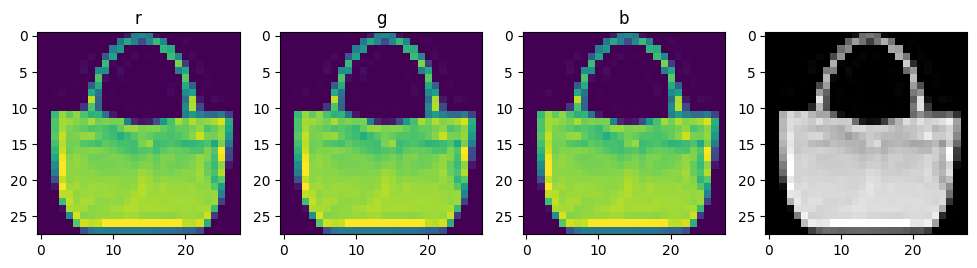

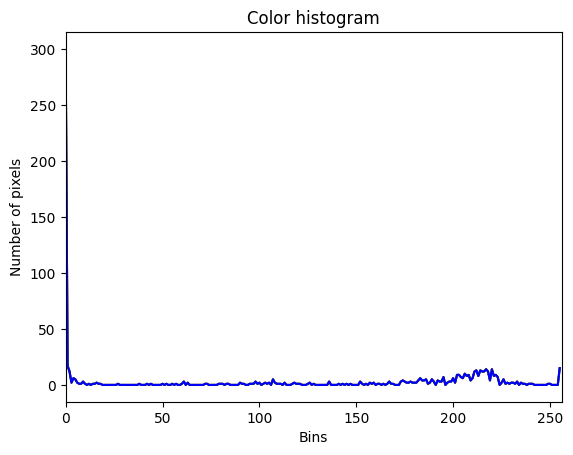

In [15]:
image_data = tf.keras.datasets.fashion_mnist
(train_img, train_labels), (test_img, test_labels) = image_data.load_data()

colors=("r", "g", "b")

# this will read the image passed and return a 3-channel histogram of it
#path = r"test_images/lenna.png"
#path = r"test_images/rgb_test.png"
#path = r"test_images/rgb_test2.webp"
#img = cv2.imread(path) # stores images in BGR format
#img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image_index = 100
img = train_img[image_index] #choice(train_img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

chans=cv2.split(img)

_, axs = plt.subplots(1, 4, figsize=(12, 12))
plt.imshow(img)
axs = axs.flatten() # works but vscode marks as an error for some reason
i = 0
for img, ax in zip(chans, axs):
    ax.set_title(colors[i])
    ax.imshow(img)
    i += 1
plt.show()

plt.figure()
plt.title("Color histogram")
plt.xlabel("Bins")
plt.ylabel("Number of pixels")
for (chan, c) in zip(chans, colors):
    hist=cv2.calcHist([chan], [0], None, [256], [0,256])
    plt.plot(hist, color=c)
    plt.xlim([0,256])
plt.show()

In [7]:
# this will divide every image in the training set into their respective channels and store them

color_representations = [] # a tuple in the form (label, image, [channels])

print(f"Dividing {len(train_img)} images into channels...")
for i in range(len(train_img)):
    chans=cv2.split(train_img[i])
    color_representations.append((train_labels[i], train_img[i], chans))
    if i % 10000 == 0:
        print(f"{i} images divided")
print(f"{i+1} images divided, Done!")

Dividing 60000 images into channels...
0 images divided
10000 images divided
20000 images divided
30000 images divided
40000 images divided
50000 images divided
60000 images divided, Done!


0 images patched
10000 images patched
20000 images patched
30000 images patched
40000 images patched
50000 images patched
60000 images patched, Done!


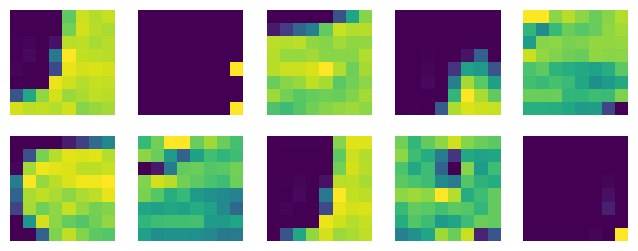

In [8]:
# returns a list of patches from the image passed
def get_patches(image, patch_size=8, n_patches=1000, random_state=10):
    patches = extract_patches_2d(image, patch_size=(patch_size, patch_size), max_patches=n_patches, random_state=10)
    return patches

# filling up the array with patches for each image
# also, both of these versions take the same amount of time to run :(

# version 1
patches_array = []
i = 0
for image in train_img:
    patches = get_patches(image)
    patches_array.append(patches)
    if i % 10000 == 0:
        print(f"{i} images patched")
    i += 1
print(f"{i} images patched, Done!")


# version 2
""" 
from joblib import Parallel, delayed
patches_array = Parallel(n_jobs=-1)(delayed(get_patches)(image) for image in train_img)
"""

# shows some of the patches
# the patches are taken from the image above
plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(patches_array[image_index][i])
    plt.axis("off")


In [40]:
# now for the SIFT part
from PIL import Image

sift = cv2.SIFT_create()
orb = cv2.ORB_create(scaleFactor=1.0, nlevels=8, edgeThreshold=31, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)

""" 
# returns a tuple of (image, keypoints, descriptors) after applying sift or orb to the image passed
def get_keypoints_descriptors(img):
    # for sift
    img = cv2.resize(img, (480, 480)) # interpolation=cv2.INTER_LINEAR
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    
    # for orb
    #keypoints, descriptors = orb.detectAndCompute(img, None)
    #img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

    return (img, keypoints, descriptors)
"""

sift_array = [] # a tuple in the form (image, keypoints, descriptors)
for i in range(len(train_img)):
    img = train_img[i]

    # resizing takes too much time, so I'll leave it at 2x
    #img = img.resize((480, 480))
    img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST) # interpolation=cv2.INTER_LINEAR
    #img = cv2.resize(image, (0, 0), fx = 2, fy = 2, interpolation=cv2.INTER_NEAREST)

    # for sift
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

    sift_array.append((img, keypoints, descriptors))
    #sift_array.append(get_keypoints_descriptors(img))
    if i % 10000 == 0:
        print(f"{i} images described using sift")
    i += 1
print(f"{i} images described, Done!")


# showing one example after training them all
img = sift_array[image_index][0]
""" img = train_img[image_index]
img = cv2.resize(img, (480, 480), interpolation=cv2.INTER_LINEAR)
img = get_keypoints_descriptors(img)[0] """
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


0 images described using sift
10000 images described using sift
20000 images described using sift
30000 images described using sift
40000 images described using sift
50000 images described using sift
60000 images described, Done!
